In [8]:
import sys, os, csv, logging, argparse, h5py
import numpy as np
import pandas as pd
from sklearn import linear_model, svm

# Parameters
stdids = ['466880', '466910', '466920', '466930', '466940', 
          'C0A520', 'C0A530', 'C0A540', 'C0A550', 'C0A560', 
          'C0A570', 'C0A580', 'C0A640', 'C0A650', 'C0A660', 
          'C0A710', 'C0A860', 'C0A870', 'C0A880', 'C0A890', 
          'C0A920', 'C0A940', 'C0A950', 'C0A970', 'C0A980', 
          'C0A9A0', 'C0A9B0', 'C0A9C0', 'C0A9E0', 'C0A9F0', 
          'C0A9G0', 'C0A9I1', 'C0AC40', 'C0AC60', 'C0AC70', 
          'C0AC80', 'C0ACA0', 'C0AD00', 'C0AD10', 'C0AD20', 
          'C0AD30', 'C0AD40', 'C0AD50', 'C0AG90', 'C0AH00']
#-----------------------------------------------------------------------
# Functions
#-----------------------------------------------------------------------
# Load input/output data for model
def loadIOTab(srcx, srcy, dropna=False):
    import pandas as pd
    import os
    # Read raw input and output
    #logging.info("Reading input X from: "+ srcx)
    logging.info("Reading input X from: "+ srcx)
    xfiles = []
    for root, dirs, files in os.walk(srcx): 
        for fn in files: 
            if fn.endswith('.npy'): 
                 xfiles.append({'date':fn.replace('.enc.npy',''), 'xuri':os.path.join(root, fn)})
    xfiles = pd.DataFrame(xfiles)
    logging.info("... read input size: "+str(xfiles.shape))
    #logging.info("Reading output Y from: "+ srcy)
    logging.info("Reading output Y from: "+ srcy)
    yraw = pd.read_csv(srcy, encoding='utf-8')
    yraw['date'] = yraw['date'].apply(str)
    logging.info("... read output size: "+str(yraw.shape))
    # Create complete IO-data
    logging.info("Pairing X-Y and splitting training/testing data.")
    iotab = pd.merge(yraw, xfiles, on='date', sort=True)
    logging.info("... data size after merging: "+str(iotab.shape))
    # Dro NA if specified
    if dropna:
        logging.info('Dropping records with NA')
        iotab = iotab.dropna()
        logging.info("... data size after dropping-NAs: "+str(iotab.shape))
    # Done
    return(iotab)

# Function to give report for binary classifications
def evaluate_binary(yt, yp, stid=None, ythresh=1.):
    from sklearn.metrics import confusion_matrix
    ytb = (yt>=ythresh)*1
    ypb = (yp>=ythresh)*1
    # Derive metrics
    output = {'id':stid}
    TN, FP, FN, TP = confusion_matrix(ytb, ypb).ravel()
    output['true_positive'] = np.round(TP,2)
    output['false_positive'] = np.round(FP,2)
    output['false_negative'] = np.round(FN,2)
    output['true_negative'] = np.round(TN,2)
    output['sensitivity'] = np.round(TP/(TP+FN),2)
    output['specificity'] = np.round(TN/(FP+TN),2)
    output['prevalence'] = np.round((TP+FN)/(FN+TP+FP+TN),8)
    output['ppv'] = np.round(TP/(TP+FP),4)
    output['npv'] = np.round(TN/(TN+FN),4)
    output['fpr'] = np.round(FP/(FP+TN),4)
    output['fnr'] = np.round(FN/(FN+TP),4)
    output['fdr'] = np.round(FP/(FP+TP),4)
    output['FOR'] = np.round(FN/(TN+FN),4)
    output['accuracy'] = np.round((TP+TN)/(FN+TP+FP+TN),4)
    output['F1'] = np.round(2*TP/(2*TP+FP+FN),4)
    output['MCC'] = np.round((TP*TN-FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),4)
    output['informedness'] = np.round(output['sensitivity'] + output['specificity'] - 1,4)
    output['markedness'] = np.round(output['ppv'] + output['npv'] -1,4)
    return(output)


In [2]:
# Data preparation
xpath='../data/qpesums_encoded/'
ypath='../examples/data/t1hr.csv'
logging.basicConfig(level=logging.DEBUG)
# IO data generation
iotab = loadIOTab(xpath, ypath, dropna=False)
logging.info('    number of total records listed: '+str(iotab.shape[0]))
# Load Input
x_full=[]
for i in range(iotab.shape[0]):
    x_full.append(np.load(iotab['xuri'].iloc[i]).flatten())
x_full = pd.DataFrame(np.array(x_full))
x_full.index = list(iotab['date'])
logging.info('    number of total records read: '+str(x_full.shape[0]))

INFO:root:Reading input X from: ../data/qpesums_encoded/
INFO:root:... read input size: (34402, 2)
INFO:root:Reading output Y from: ../examples/data/t1hr.csv
INFO:root:... read output size: (35064, 46)
INFO:root:Pairing X-Y and splitting training/testing data.
INFO:root:... data size after merging: (32953, 47)
INFO:root:    number of total records listed: 32953
INFO:root:    number of total records read: 32953


In [36]:
# Loop through stations
report_train = []
report_test = []
for sid in stdids:
    # Create iotable for the station
    logging.info('Station id: '+sid)
    stdio = iotab.loc[:,['date', sid]].merge(x_full, left_on='date', right_index=True).dropna().reset_index(drop=True)
    logging.info('    number of valid records: '+str(stdio.shape[0]))
    y = (stdio[sid]>=30.)*1
    x = stdio.iloc[:, 2:]
    # Split training and testing data
    idx2016 = np.floor(stdio['date'].astype(float)/1000000.) == 2016
    size_of_2016 = sum(idx2016)
    size_before_2016 = sum(stdio['date'].astype(int)<2016010100)
    logging.info('    Data index of 2016: '+str(size_of_2016))
    y_train = y.loc[~idx2016]
    x_train = x.loc[~idx2016,:]
    # Reporting training/testing size
    logging.info('    Data dimension of training data: '+str(x_train.shape[0]) + ', ' +str(x_train.shape[1]))
    y_test = y.loc[idx2016].reset_index(drop=True)
    x_test = x.loc[idx2016,:].reset_index(drop=True)
    logging.info('    Data dimension of testing data: '+str(x_test.shape[0]) + ', ' +str(x_test.shape[1]))
    # Train model and test
    #cls = linear_model.LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000, C=0.1)
    cls = svm.SVC(C=0.1, kernel='rbf', degree=4, gamma='scale', coef0=0.0, class_weight='balanced')
    cls.fit(x_train, y_train)
    yp_train = cls.predict(x_train)
    yp_test = cls.predict(x_test)
    # Evaluate
    evtrain = evaluate_binary(y_train, yp_train, stid=sid)
    report_train.append(evtrain)
    logging.info(evtrain)
    evtest = evaluate_binary(y_test, yp_test, stid=sid)
    report_test.append(evtest)
    logging.info(evtest)


INFO:root:Station id: 466880
INFO:root:    number of valid records: 30321
INFO:root:    Data index of 2016: 7258
INFO:root:    Data dimension of training data: 23063, 64
INFO:root:    Data dimension of testing data: 7258, 64
INFO:root:{'id': '466880', 'true_positive': 19, 'false_positive': 231, 'false_negative': 0, 'true_negative': 22813, 'sensitivity': 1.0, 'specificity': 0.99, 'prevalence': 0.00082383, 'ppv': 0.076, 'npv': 1.0, 'fpr': 0.01, 'fnr': 0.0, 'fdr': 0.924, 'FOR': 0.0, 'accuracy': 0.99, 'F1': 0.1413, 'MCC': 0.2743, 'informedness': 0.99, 'markedness': 0.076}
INFO:root:{'id': '466880', 'true_positive': 7, 'false_positive': 108, 'false_negative': 1, 'true_negative': 7142, 'sensitivity': 0.88, 'specificity': 0.99, 'prevalence': 0.00110223, 'ppv': 0.0609, 'npv': 0.9999, 'fpr': 0.0149, 'fnr': 0.125, 'fdr': 0.9391, 'FOR': 0.0001, 'accuracy': 0.985, 'F1': 0.1138, 'MCC': 0.2285, 'informedness': 0.87, 'markedness': 0.0608}
INFO:root:Station id: 466910
INFO:root:    number of valid rec

INFO:root:Station id: C0A560
INFO:root:    number of valid records: 31457
INFO:root:    Data index of 2016: 7358
INFO:root:    Data dimension of training data: 24099, 64
INFO:root:    Data dimension of testing data: 7358, 64
INFO:root:{'id': 'C0A560', 'true_positive': 41, 'false_positive': 236, 'false_negative': 0, 'true_negative': 23822, 'sensitivity': 1.0, 'specificity': 0.99, 'prevalence': 0.00170132, 'ppv': 0.148, 'npv': 1.0, 'fpr': 0.0098, 'fnr': 0.0, 'fdr': 0.852, 'FOR': 0.0, 'accuracy': 0.9902, 'F1': 0.2579, 'MCC': 0.3828, 'informedness': 0.99, 'markedness': 0.148}
INFO:root:{'id': 'C0A560', 'true_positive': 16, 'false_positive': 107, 'false_negative': 0, 'true_negative': 7235, 'sensitivity': 1.0, 'specificity': 0.99, 'prevalence': 0.0021745, 'ppv': 0.1301, 'npv': 1.0, 'fpr': 0.0146, 'fnr': 0.0, 'fdr': 0.8699, 'FOR': 0.0, 'accuracy': 0.9855, 'F1': 0.2302, 'MCC': 0.358, 'informedness': 0.99, 'markedness': 0.1301}
INFO:root:Station id: C0A570
INFO:root:    number of valid records:

INFO:root:Station id: C0A880
INFO:root:    number of valid records: 31938
INFO:root:    Data index of 2016: 7636
INFO:root:    Data dimension of training data: 24302, 64
INFO:root:    Data dimension of testing data: 7636, 64
INFO:root:{'id': 'C0A880', 'true_positive': 13, 'false_positive': 231, 'false_negative': 0, 'true_negative': 24058, 'sensitivity': 1.0, 'specificity': 0.99, 'prevalence': 0.00053494, 'ppv': 0.0533, 'npv': 1.0, 'fpr': 0.0095, 'fnr': 0.0, 'fdr': 0.9467, 'FOR': 0.0, 'accuracy': 0.9905, 'F1': 0.1012, 'MCC': 0.2297, 'informedness': 0.99, 'markedness': 0.0533}
INFO:root:{'id': 'C0A880', 'true_positive': 7, 'false_positive': 107, 'false_negative': 0, 'true_negative': 7522, 'sensitivity': 1.0, 'specificity': 0.99, 'prevalence': 0.00091671, 'ppv': 0.0614, 'npv': 1.0, 'fpr': 0.014, 'fnr': 0.0, 'fdr': 0.9386, 'FOR': 0.0, 'accuracy': 0.986, 'F1': 0.1157, 'MCC': 0.2461, 'informedness': 0.99, 'markedness': 0.0614}
INFO:root:Station id: C0A890
INFO:root:    number of valid record

INFO:root:Station id: C0A9C0
INFO:root:    number of valid records: 31268
INFO:root:    Data index of 2016: 7862
INFO:root:    Data dimension of training data: 23406, 64
INFO:root:    Data dimension of testing data: 7862, 64
INFO:root:{'id': 'C0A9C0', 'true_positive': 24, 'false_positive': 198, 'false_negative': 0, 'true_negative': 23184, 'sensitivity': 1.0, 'specificity': 0.99, 'prevalence': 0.00102538, 'ppv': 0.1081, 'npv': 1.0, 'fpr': 0.0085, 'fnr': 0.0, 'fdr': 0.8919, 'FOR': 0.0, 'accuracy': 0.9915, 'F1': 0.1951, 'MCC': 0.3274, 'informedness': 0.99, 'markedness': 0.1081}
INFO:root:{'id': 'C0A9C0', 'true_positive': 2, 'false_positive': 115, 'false_negative': 0, 'true_negative': 7745, 'sensitivity': 1.0, 'specificity': 0.99, 'prevalence': 0.00025439, 'ppv': 0.0171, 'npv': 1.0, 'fpr': 0.0146, 'fnr': 0.0, 'fdr': 0.9829, 'FOR': 0.0, 'accuracy': 0.9854, 'F1': 0.0336, 'MCC': 0.1298, 'informedness': 0.99, 'markedness': 0.0171}
INFO:root:Station id: C0A9E0
INFO:root:    number of valid reco

INFO:root:Station id: C0ACA0
INFO:root:    number of valid records: 32171
INFO:root:    Data index of 2016: 7731
INFO:root:    Data dimension of training data: 24440, 64
INFO:root:    Data dimension of testing data: 7731, 64
INFO:root:{'id': 'C0ACA0', 'true_positive': 8, 'false_positive': 219, 'false_negative': 0, 'true_negative': 24213, 'sensitivity': 1.0, 'specificity': 0.99, 'prevalence': 0.00032733, 'ppv': 0.0352, 'npv': 1.0, 'fpr': 0.009, 'fnr': 0.0, 'fdr': 0.9648, 'FOR': 0.0, 'accuracy': 0.991, 'F1': 0.0681, 'MCC': 0.1869, 'informedness': 0.99, 'markedness': 0.0352}
INFO:root:{'id': 'C0ACA0', 'true_positive': 4, 'false_positive': 105, 'false_negative': 3, 'true_negative': 7619, 'sensitivity': 0.57, 'specificity': 0.99, 'prevalence': 0.00090545, 'ppv': 0.0367, 'npv': 0.9996, 'fpr': 0.0136, 'fnr': 0.4286, 'fdr': 0.9633, 'FOR': 0.0004, 'accuracy': 0.986, 'F1': 0.069, 'MCC': 0.1423, 'informedness': 0.56, 'markedness': 0.0363}
INFO:root:Station id: C0AD00
INFO:root:    number of valid

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


       true_positive  false_positive  false_negative  true_negative  \
count      45.000000       45.000000       45.000000      45.000000   
mean        6.355556      108.066667        0.888889    7464.377778   
std         4.390877       17.303967        0.934739     246.953003   
min         1.000000       28.000000        0.000000    6444.000000   
25%         3.000000      104.000000        0.000000    7303.000000   
50%         5.000000      110.000000        1.000000    7513.000000   
75%         9.000000      120.000000        1.000000    7650.000000   
max        16.000000      130.000000        3.000000    7772.000000   

       sensitivity  specificity  prevalence        ppv        npv        fpr  \
count    45.000000    45.000000   45.000000  45.000000  45.000000  45.000000   
mean      0.856222     0.986889    0.000961   0.054580   0.999893   0.014260   
std       0.162037     0.005144    0.000588   0.035025   0.000132   0.002187   
min       0.400000     0.980000    0.000

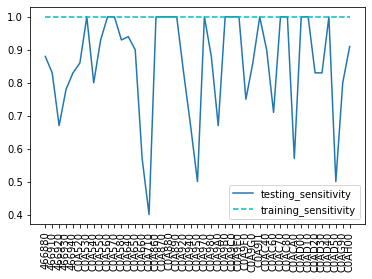

In [37]:
report_train = pd.DataFrame(report_train)
report_test = pd.DataFrame(report_test)

print(report_test.describe())


%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(report_test['sensitivity'], '-', label='testing_sensitivity')
plt.plot(report_train['sensitivity'], '--c', label='training_sensitivity')
plt.xticks(np.arange(45), report_test['id'], rotation='90')
plt.legend()
plt.show()

In [38]:
report_test.to_csv('enc_bc_svm_test.csv')